https://doi.pangaea.de/10.1594/PANGAEA.886889

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt

In [76]:
fname_position = pooch.retrieve(
    url="https://store.pangaea.de/Publications/Sanchez-etal_2018/ALPS2017_NEH.CRD",
    known_hash="sha256:24b88a0e5ab6ea93c67424ef52542d8b8a8254a150284e1a54afddbfd93e4399",
)
fname_velocity = pooch.retrieve(
    url="https://store.pangaea.de/Publications/Sanchez-etal_2018/ALPS2017_NEH.VEL",
    known_hash="sha256:0f2eff87a39260e2b3218897763dbfecdf0f464bf877bef460eff34a70e00aa7",
)
fname_velocity_eurasia = pooch.retrieve(
    url="https://store.pangaea.de/Publications/Sanchez-etal_2018/ALPS2017_REP.VEL",
    known_hash="sha256:578677246230e893c828205391d262da4af39bb24a8ca66ff5a95a88c71fe509",
)

In [100]:
station_horizontal = []
velocity_north_mm_yr = []
velocity_north_error_mm_yr = []
velocity_east_mm_yr = []
velocity_east_error_mm_yr = []
velocity_up_mm_yr = []
velocity_up_error_mm_yr = []
with open(fname_velocity_eurasia, encoding="latin-1") as input_file:
    for i, line in enumerate(input_file):
        if i < 19 or not line.strip():
            continue
        columns = line.split()
        station_id = columns[0]
        if station_id == "CH1Z":
            station_id = "CHIZ"
        if station_id == "IE1G":
            station_id = "IENG"
        values = columns[3:]
        station_horizontal.append(station_id)
        velocity_east_mm_yr.append(1e3 * float(values[0]))
        velocity_north_mm_yr.append(1e3 * float(values[1]))
        velocity_east_error_mm_yr.append(1e3 * float(values[2]))
        velocity_north_error_mm_yr.append(1e3 * float(values[3]))
print(len(station_horizontal))

186


In [106]:
station = []
latitude = []
latitude_error_m = []
longitude = []
longitude_error_m = []
height_m = []
height_error_m = []
with open(fname_position, encoding="latin-1") as input_file:
    for i, line in enumerate(input_file):
        if i < 15 or i > 304 or not line.strip():
            continue
        columns = line.split()
        if len(columns) == 12:
            station_id = columns[0]
            values = columns[2:8]
        else:
            station_id = columns[0]
            values = columns[1:7]
        # Skip repeated stations because it's easier this way
        if station_id not in station_horizontal:
            continue
        if station_id in station:
            continue
        values = [float(x) for x in values]
        # Make longitude be in [-180, 180] for easier plotting
        if values[2] > 300:
            values[2] -= 360
        station.append(station_id)
        latitude.append(values[0])
        latitude_error_m.append(values[1])
        longitude.append(values[2])
        longitude_error_m.append(values[3])
        height_m.append(values[4])
        height_error_m.append(values[5])
print(len(station))

186


In [107]:
station = []
velocity_up_mm_yr = []
velocity_up_error_mm_yr = []
with open(fname_velocity, encoding="latin-1") as input_file:
    for i, line in enumerate(input_file):
        if i < 15 or i > 303 or not line.strip():
            continue
        columns = line.split()        
        if len(columns) == 12:
            station_id = columns[0]
            values = columns[6:8]
        else:
            station_id = columns[0]
            values = columns[5:7]
        # Skip repeated stations because it's easier this way
        if station_id in station or station_id not in station_horizontal:
            continue
        station.append(station_id)
        velocity_up_mm_yr.append(1e3 * float(values[0]))
        velocity_up_error_mm_yr.append(1e3 * float(values[1]))
print(len(station))

186


In [108]:
data = pd.DataFrame({
    "station_id": station,    
    "latitude": latitude,
    "latitude_error_m": latitude_error_m,
    "longitude": longitude,
    "longitude_error_m": longitude_error_m,
    "height_m": height_m,
    "height_error_m": height_error_m,
    "velocity_north_mmyr": velocity_north_mm_yr,
    "velocity_north_error_mmyr": velocity_north_error_mm_yr,
    "velocity_east_mmyr": velocity_east_mm_yr,
    "velocity_east_error_mmyr": velocity_east_error_mm_yr,
    "velocity_up_mmyr": velocity_up_mm_yr,
    "velocity_up_error_mmyr": velocity_up_error_mm_yr,
})
data

,station_id,latitude,latitude_error_m,longitude,longitude_error_m,height_m,height_error_m,velocity_north_mmyr,velocity_north_error_mmyr,velocity_east_mmyr,velocity_east_error_mmyr,velocity_up_mmyr,velocity_up_error_mmyr
0,ACOM,46.547935,0.0009,13.514900,0.0005,1774.682,0.001,1.2,0.1,0.2,0.1,1.1,0.1
1,AFAL,46.527144,0.0009,12.174517,0.0009,2284.085,0.001,0.9,0.2,-0.7,0.1,1.3,0.2
2,AGDE,43.296383,0.0018,3.466427,0.0009,65.785,0.002,-0.2,0.3,-0.2,0.1,0.1,0.3
3,AGNE,45.467942,0.0036,7.139620,0.0009,2354.600,0.004,-0.2,0.6,0.0,0.2,1.5,0.5
4,AIGL,44.121398,0.0009,3.581261,0.0009,1618.764,0.002,0.1,0.5,0.0,0.1,0.7,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,WLBH,48.415171,0.0009,7.351299,0.0005,819.069,0.001,-0.2,0.2,0.0,0.1,-2.8,0.2
182,WTZR,49.144199,0.0005,12.878911,0.0005,666.025,0.001,0.2,0.1,0.1,0.1,-0.1,0.1
183,ZADA,44.113177,0.0036,15.227590,0.0018,64.307,0.004,3.1,0.4,0.2,0.2,-0.3,0.4
184,ZIMM,46.877098,0.0009,7.465278,0.0005,956.341,0.001,0.4,0.1,-0.1,0.1,1.0,0.1


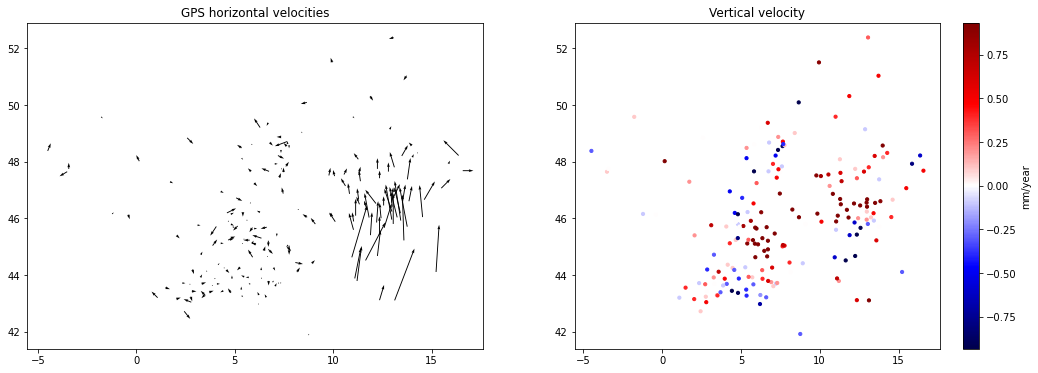

In [131]:
fig, axes = plt.subplots(
    1, 2, figsize=(18, 6)
)
# Plot the horizontal velocity vectors
ax = axes[0]
ax.set_title("GPS horizontal velocities")
ax.quiver(
    data.longitude.values,
    data.latitude.values,
    data.velocity_east_mmyr.values,
    data.velocity_north_mmyr.values,
    scale=30,
    width=0.002,
)
# Plot the vertical velocity
ax = axes[1]
ax.set_title("Vertical velocity")
maxabs = vd.maxabs(data.velocity_up_mmyr)
tmp = ax.scatter(
    data.longitude,
    data.latitude,
    c=data.velocity_up_mmyr,
    s=10,
    vmin=-maxabs / 3,
    vmax=maxabs / 3,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax).set_label("mm/year")
plt.show()